<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M0.532 · Pattern Recognition</p>
<p style="margin: 0; text-align:right;">Computational Engineering and Mathematics Master</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Computers, Multimedia and Telecommunications Department</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

In this notebook, we will see an implementations of optical flow based on convolutional neuronal networks, [FlowNet 2.0](https://arxiv.org/abs/1612.01925). We have created this notebook based on [this other notebook](https://github.com/Gauravv97/flownet2-Colab/blob/master/Flownet2_Colab.ipynb).

First of all, we download the compatible version of Torch.

In [ ]:
!pip install torch==1.0.0 torchvision==0.2.2 -f https://download.pytorch.org/whl/cu90/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu90/torch_stable.html
     |████████████████████████████████| 591.8 MB 667 bytes/s 
     |████████████████████████████████| 64 kB 2.7 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.3
    Uninstalling tqdm-4.62.3:
      Successfully uninstalled tqdm-4.62.3
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.0.0 wh

Then, we clone the FlowNet2 github repository and we install the required libraries.

In [ ]:
import os
# get flownet2-pytorch source
!git clone https://github.com/Gauravv97/flownet2-pytorch.git
!mv /content/flownet2-pytorch /content/flownet2pytorch
os.chdir('./flownet2pytorch')
# install custom layers
!bash install.sh

Cloning into 'flownet2-pytorch'...
remote: Enumerating objects: 572, done.
remote: Total 572 (delta 0), reused 0 (delta 0), pack-reused 572
Receiving objects: 100% (572/572), 6.28 MiB | 24.84 MiB/s, done.
Resolving deltas: 100% (323/323), done.
running install
running bdist_egg
running egg_info
creating correlation_cuda.egg-info
writing correlation_cuda.egg-info/PKG-INFO
writing dependency_links to correlation_cuda.egg-info/dependency_links.txt
writing top-level names to correlation_cuda.egg-info/top_level.txt
writing manifest file 'correlation_cuda.egg-info/SOURCES.txt'
writing manifest file 'correlation_cuda.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_ext
building 'correlation_cuda' extension
creating build
creating build/temp.linux-x86_64-3.7
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-Y7dWVB/python3.7-3.7.12=. -fstack-protector

We add the necessary packages to the system path.

In [ ]:
import os
os.sys.path.append('/root/.local/lib/python3.6/site-packages/resample2d_cuda-0.0.0-py3.6-linux-x86_64.egg')
os.sys.path.append('/root/.local/lib/python3.6/site-packages/correlation_cuda-0.0.0-py3.6-linux-x86_64.egg')
os.sys.path.append( '/root/.local/lib/python3.6/site-packages/channelnorm_cuda-0.0.0-py3.6-linux-x86_64.egg')

We install some additional packages required.

In [ ]:
!pip install pypng
!pip install tensorboardx
!pip install  setproctitle colorama scipy==1.1.0

     |████████████████████████████████| 48 kB 3.8 MB/s 
     |████████████████████████████████| 124 kB 15.4 MB/s 
     |████████████████████████████████| 31.2 MB 1.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.4 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
jax 0.2.25 requires scipy>=1.2.1, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Then, we download the FlowNet2 pre-trained model.

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1hF8vS6YeHkx3j2pfCeQqqZGwA_PJq_Da',dest_path='./FlowNet2_checkpoint.pth.tar')

We also download the video that we will use for inference to compute the optical flow. We will use the same video as in the previous notebook, where we have seen two classical implementations of optical flow.

In [ ]:
!wget https://www.bogotobogo.com/python/OpenCV_Python/images/mean_shift_tracking/slow_traffic_small.mp4

--2021-12-31 13:09:01--  https://www.bogotobogo.com/python/OpenCV_Python/images/mean_shift_tracking/slow_traffic_small.mp4
Resolving www.bogotobogo.com (www.bogotobogo.com)... 173.254.30.214
Connecting to www.bogotobogo.com (www.bogotobogo.com)|173.254.30.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2018126 (1.9M) [video/mp4]
Saving to: ‘slow_traffic_small.mp4’

slow_traffic_small. 100%[===================>]   1.92M  2.12MB/s    in 0.9s    

2021-12-31 13:09:03 (2.12 MB/s) - ‘slow_traffic_small.mp4’ saved [2018126/2018126]



We define an auxiliar function to create a directory if it does not exist.

In [ ]:
import os
def mkdir_ifnotexists(dir):
    if os.path.exists(dir):
        return
    os.mkdir(dir)

We extract the frames from the given input video.

In [ ]:
vid_file='./slow_traffic_small.mp4'
frame_pth='./frames'
mkdir_ifnotexists(frame_pth)
cmd = "ffmpeg -i %s -start_number 0 -vsync 0 %s/frame_%%06d.png" % (
            vid_file,
            frame_pth,
        )
os.system(cmd)

0

We can generate the optical flow files (.flo) running the FlowNet2 pretrained model for inference with the main.py script.

In [ ]:
!python main.py --inference --model FlowNet2 --save_flow --save ./output --inference_dataset ImagesFromFolder --inference_dataset_root ./frames/ --resume ./FlowNet2_checkpoint.pth.tar

Parsing Arguments
  [0.025s] batch_size: 8
  [0.025s] crop_size: [256, 256]
  [0.025s] fp16: False
  [0.025s] fp16_scale: 1024.0
  [0.025s] gradient_clip: None
  [0.025s] inference: True
  [0.025s] inference_batch_size: 1
  [0.025s] inference_dataset: ImagesFromFolder
  [0.025s] inference_dataset_iext: png
  [0.025s] inference_dataset_replicates: 1
  [0.025s] inference_dataset_root: ./frames/
  [0.025s] inference_n_batches: -1
  [0.025s] inference_size: [-1, -1]
  [0.025s] inference_visualize: False
  [0.025s] log_frequency: 1
  [0.025s] loss: L1Loss
  [0.025s] model: FlowNet2
  [0.025s] model_batchNorm: False
  [0.025s] model_div_flow: 20.0
  [0.026s] name: run
  [0.026s] no_cuda: False
  [0.026s] number_gpus: 1
  [0.026s] number_workers: 8
  [0.026s] optimizer: Adam
  [0.026s] optimizer_amsgrad: False
  [0.026s] optimizer_betas: (0.9, 0.999)
  [0.026s] optimizer_eps: 1e-08
  [0.026s] optimizer_lr: 0.001
  [0.026s] optimizer_weight_decay: 0
  [0.026s] render_validation: False
  [0.026

The rest of the code of this notebook is just for visualization purposes, since the optical flow has been already computed.

We need to install the scipy since some tensorflow utility requires updated version.

In [ ]:
!pip install scipy==1.4.1

     |████████████████████████████████| 26.1 MB 1.6 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.1.0
    Uninstalling scipy-1.1.0:
      Successfully uninstalled scipy-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
os.chdir('/content/flownet2pytorch')

We define the show_flow function to visualize the optical flow map using matplotlib. The original source code can be found [here](https://github.com/sampepose/flownet2-tf/blob/master/src/flowlib.py).

In [ ]:
# Source:https://github.com/sampepose/flownet2-tf/blob/master/src/flowlib.py
import matplotlib.pyplot as plt
import numpy as np

UNKNOWN_FLOW_THRESH = 1e7
def show_flow(filename):
    """
    visualize optical flow map using matplotlib
    :param filename: optical flow file
    :return: None
    """
    flow = read_flow(filename)
    img = flow_to_image(flow)
    plt.imshow(img)
    plt.show()

def read_flow(filename):
    """
    read optical flow from Middlebury .flo file
    :param filename: name of the flow file
    :return: optical flow data in matrix
    """
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)
    data2d = None

    if 202021.25 != magic:
        print ('Magic number incorrect. Invalid .flo file')
    else:
        w = int(np.fromfile(f, np.int32, count=1)[0])
        h = int(np.fromfile(f, np.int32, count=1)[0])
        #print("Reading %d x %d flo file" % (h, w))
        data2d = np.fromfile(f, np.float32, count=2 * w * h)
        # reshape data into 3D array (columns, rows, channels)
        data2d = np.resize(data2d, (h, w, 2))
    f.close()
    return data2d

def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    #print( "max flow: %.4f\nflow range:\nu = %.3f .. %.3f\nv = %.3f .. %.3f" % (maxrad, minu,maxu, minv, maxv))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)


def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img


def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

We show the optical flow computed on the first pair of frames of the given input video.

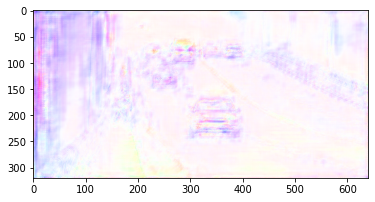

In [ ]:
show_flow('/content/flownet2pytorch/output/inference/run.epoch-0-flow-field/000001.flo')

Finally, we save the Flo files as images and we generate a video with these images.

In [ ]:
import os
import PIL.Image
def mkdir_ifnotexists(dir):
    if os.path.exists(dir):
        return
    os.mkdir(dir)


flo_pth='/content/flownet2pytorch/output/inference/run.epoch-0-flow-field/'
flos=[flo_pth + f for f in os.listdir(flo_pth)]
mkdir_ifnotexists('./FlowFrames')
for i in range(len(flos)):
 PIL.Image.fromarray(flow_to_image(read_flow(flos[i]))).save('./FlowFrames/'+os.path.basename(flos[i])+'.png')

In [ ]:
os.system('ffmpeg -r 24 -i FlowFrames/%6d.flo.png -vcodec libx264 -b 10M -y FlowVideo.mp4  ')

0

We can visualize the generated video of the optical flow.

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('/content/flownet2pytorch/FlowVideo.mp4', width=640, height=320)